In [ ]:
!apt-get install -y gdal-bin


In [ ]:
!pip install rasterio matplotlib


In [ ]:
!pip install h5py


# Import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import h5py
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, ReLU, Concatenate
from tensorflow.keras.models import Model
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# 1- Dataset Exploration

### 1.1 Overview of WorldView-3 Pansharpening Dataset in HDF5 Format

In [ ]:
# Path to the .h5 file
h5_file_path = '/content/drive/MyDrive/pansharpening/train_wv3.h5'

# Open the HDF5 file in read mode
with h5py.File(h5_file_path, 'r') as h5_file:
    # List all groups (top-level datasets or groups)
    print("Keys in the HDF5 file:")
    print(list(h5_file.keys()))

    # If you expect images inside specific groups, you can inspect them further:
    for key in h5_file.keys():
        print(f"\nInspecting group/dataset: {key}")
        dataset = h5_file[key]
        print(f"Shape: {dataset.shape}")
        print(f"Data Type: {dataset.dtype}")


Keys in the HDF5 file:
['gt', 'lms', 'ms', 'pan']

Inspecting group/dataset: gt
Shape: (9714, 8, 64, 64)
Data Type: float64

Inspecting group/dataset: lms
Shape: (9714, 8, 64, 64)
Data Type: float64

Inspecting group/dataset: ms
Shape: (9714, 8, 16, 16)
Data Type: float64

Inspecting group/dataset: pan
Shape: (9714, 1, 64, 64)
Data Type: float64


Datasets:
gt: (9714, 8, 64, 64) — ground truth (high-resolution multispectral data).

lms: (9714, 8, 64, 64) — low-resolution multispectral data.

ms: (9714, 8, 16, 16) — another form of multispectral data, likely lower resolution.

pan: (9714, 1, 64, 64) — panchromatic data.

### 1.2 Exploring WorldView-3 Pansharpening Dataset Using HDF5 File Format

In [ ]:
# Path to your .h5 file
h5_file_path = '/content/drive/MyDrive/pansharpening/train_wv3.h5'

# Open the HDF5 file
with h5py.File(h5_file_path, 'r') as h5_file:
    # Load a batch of images from the dataset
    pan_data = h5_file['pan'][:100]
    ms_data = h5_file['ms'][:100]
    lms_data = h5_file['lms'][:100]
    gt_data = h5_file['gt'][:100]

    # Access the first sample of PAN and MS data
    pan_image = pan_data[0]
    ms_image = ms_data[0]
    lms_image = ms_data[0]
    gt_image = gt_data[0]

    # Display the shapes of the images
    print("PAN image shape:", pan_image.shape)
    print("MS image shape:", ms_image.shape)
    print("LMS image shape:", lms_image.shape)
    print("Ground truth shape:", gt_image.shape)


PAN image shape: (1, 64, 64)
MS image shape: (8, 16, 16)
LMS image shape: (8, 16, 16)
Ground truth shape: (8, 64, 64)


### 1.3 Comparison of PAN and Multispectral (MS) Images from the Pansharpening Dataset

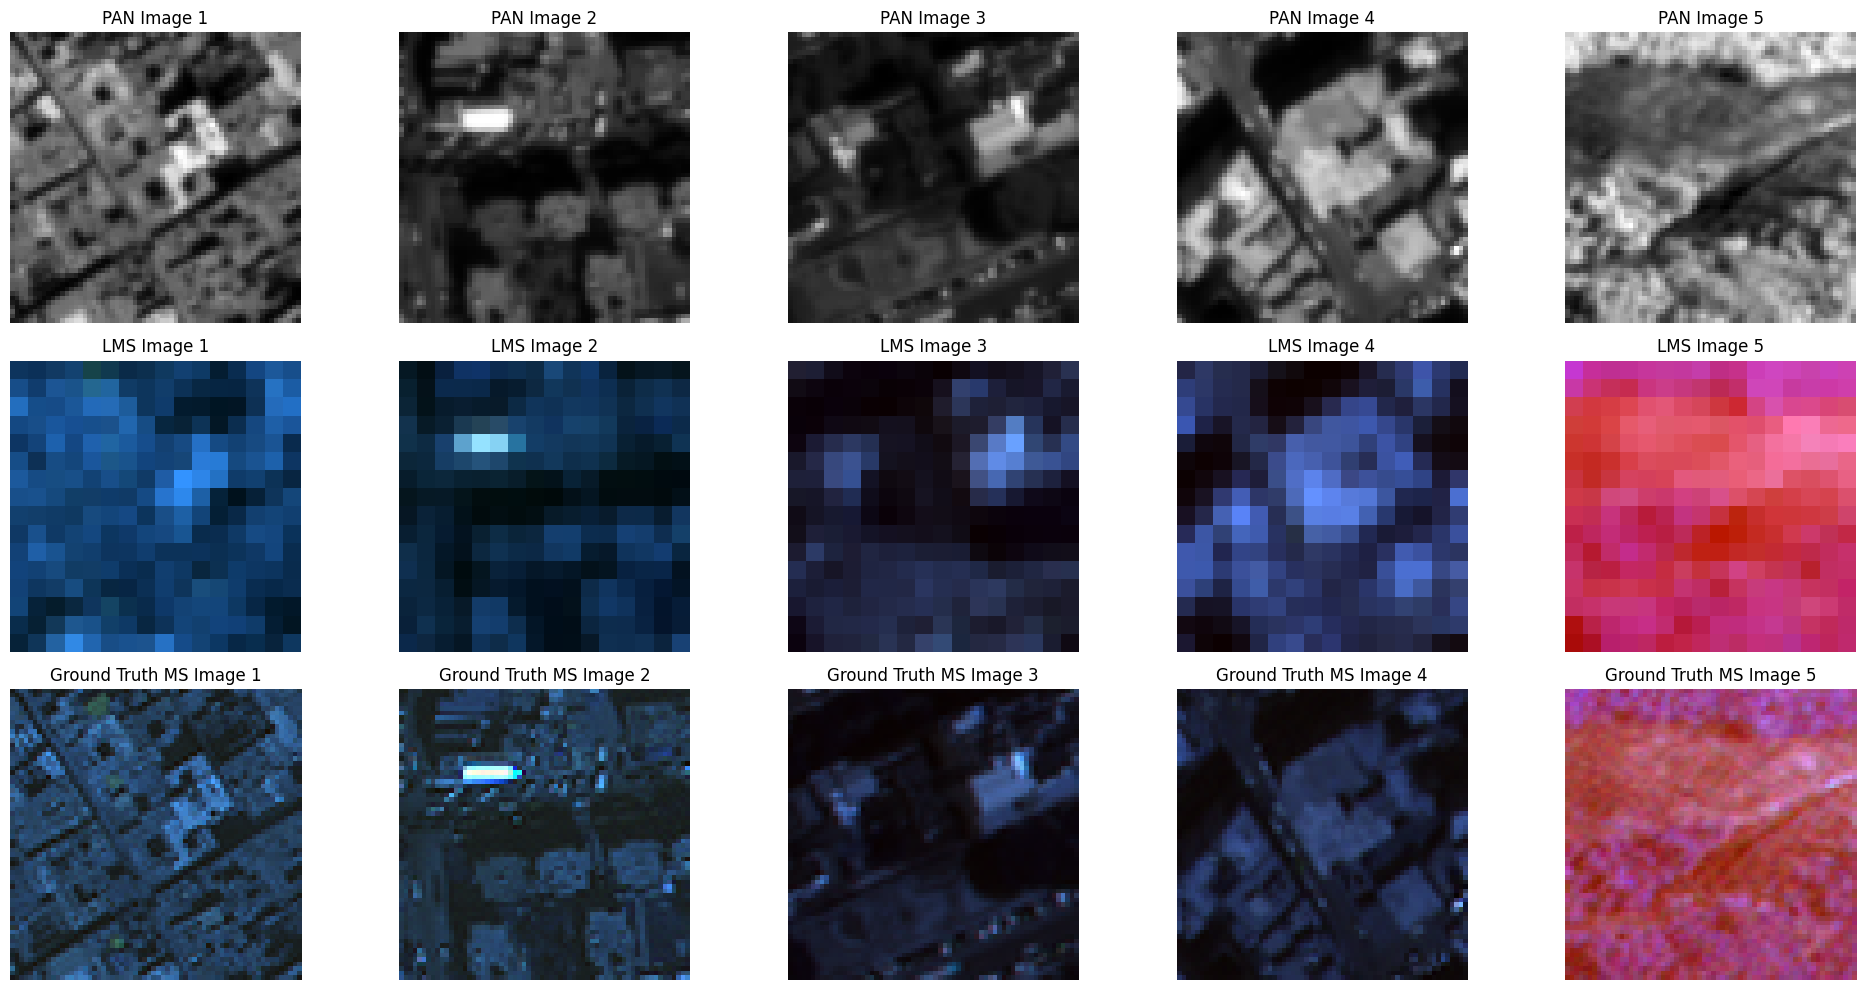

In [3]:
# Path to your .h5 file
h5_file_path = '/content/drive/MyDrive/pansharpening/train_wv3.h5'

# Open the HDF5 file
with h5py.File(h5_file_path, 'r') as h5_file:
    # Load a batch of images
    pan_data = h5_file['pan'][:5]  # Load first 5 samples of PAN images (1 channel, 64x64)
    ms_data = h5_file['ms'][:5]  # Load first 5 samples of low-resolution MS images (8 channels, 16x16)
    gt_data = h5_file['gt'][:5]  # Load first 5 samples of high-resolution ground truth MS images (8 channels, 64x64)

# Function to normalize images for display
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Plot the PAN, LMS, and Ground Truth MS images
plt.figure(figsize=(20, 10))

# Display PAN images (grayscale)
for i in range(5):
    pan_image = pan_data[i].squeeze()  # Squeeze to remove extra channel dimension (shape: 64x64)
    normalized_pan = normalize_image(pan_image)  # Normalize for display

    plt.subplot(3, 5, i + 1)  # Row 1 for PAN images
    plt.imshow(normalized_pan, cmap='gray')
    plt.title(f'PAN Image {i+1}')
    plt.axis('off')

# Display LMS images (RGB using 3 bands: Red, Green, Blue)
for i in range(5):
    lms_image = ms_data[i][:3]  # Select first 3 bands for RGB visualization (shape: 3x16x16)
    lms_image_resized = np.repeat(np.repeat(lms_image, 4, axis=1), 4, axis=2)  # Resize from 16x16 to 64x64
    lms_rgb = np.dstack(lms_image_resized)  # Stack the bands to form an RGB image
    normalized_lms = normalize_image(lms_rgb)  # Normalize for display

    plt.subplot(3, 5, i + 6)  # Row 2 for LMS images
    plt.imshow(normalized_lms)
    plt.title(f'LMS Image {i+1}')
    plt.axis('off')

# Display Ground Truth MS images (RGB using 3 bands: Red, Green, Blue)
for i in range(5):
    gt_image = gt_data[i][:3]  # Select first 3 bands for RGB visualization (shape: 3x64x64)
    gt_rgb = np.dstack(gt_image)  # Stack the bands to form an RGB image
    normalized_gt = normalize_image(gt_rgb)  # Normalize for display

    plt.subplot(3, 5, i + 11)  # Row 3 for Ground Truth MS images
    plt.imshow(normalized_gt)
    plt.title(f'Ground Truth MS Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# 2- Preprocessing

### 2.1 Dataset Class for Loading and Processing PAN, LMS, and Ground Truth MS Images for Pansharpening from HDF5 Files

In [ ]:
# Dataset class for loading PAN, LMS, and ground truth MS images from HDF5
class HDF5PansharpeningDataset(Dataset):
    def __init__(self, h5_file_path):
        self.h5_file_path = h5_file_path

        # Open the HDF5 file and read the datasets
        with h5py.File(self.h5_file_path, 'r') as h5_file:
            self.pan_data = h5_file['pan'][:]  # Load PAN data (1, 64, 64)
            self.lms_data = h5_file['lms'][:]  # Load low-resolution MS data (8, 16, 16)
            self.gt_data = h5_file['gt'][:]  # Load high-resolution MS ground truth (8, 64, 64)

    def __len__(self):
        return len(self.pan_data)

    def __getitem__(self, idx):
        pan_image = self.pan_data[idx]  # Shape (1, 64, 64)
        lms_image = self.lms_data[idx]  # Shape (8, 16, 16)
        gt_image = self.gt_data[idx]  # Ground truth shape (8, 64, 64)

        # Upsample the low-resolution MS image to match the PAN image resolution (64x64)
        lms_image_upsampled = cv2.resize(lms_image.transpose(1, 2, 0), (64, 64), interpolation=cv2.INTER_CUBIC)
        lms_image_upsampled = lms_image_upsampled.transpose(2, 0, 1)  # Transpose back to (C, H, W)

        # Normalize PAN, LMS, and GT images to [0, 1]
        pan_image = pan_image.astype('float32') / 255.0
        lms_image_upsampled = lms_image_upsampled.astype('float32') / 255.0
        gt_image = gt_image.astype('float32') / 255.0

        # Convert to Torch tensors
        pan_image_tensor = torch.from_numpy(pan_image)  # (1, 64, 64)
        lms_image_tensor = torch.from_numpy(lms_image_upsampled)  # (8, 64, 64)
        gt_image_tensor = torch.from_numpy(gt_image)  # (8, 64, 64)

        return pan_image_tensor, lms_image_tensor, gt_image_tensor

# Load the dataset
h5_file_path = '/content/drive/MyDrive/pansharpening/train_wv3.h5'
dataset = HDF5PansharpeningDataset(h5_file_path)

# Define the DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# how to iterate through the DataLoader
for pan_image_batch, lms_image_batch, gt_image_batch in dataloader:
    print(f"PAN image batch shape: {pan_image_batch.shape}")
    print(f"LMS image batch shape: {lms_image_batch.shape}")
    print(f"Ground truth batch shape: {gt_image_batch.shape}")
    break


PAN image batch shape: torch.Size([8, 1, 64, 64])
LMS image batch shape: torch.Size([8, 8, 64, 64])
Ground truth batch shape: torch.Size([8, 8, 64, 64])


# 3- Setting Up Pix2Pix for Pansharpening

### 3.1 Subsampling Dataset to 10% for Efficient Processing of PAN, MS, and Ground Truth Data



In [ ]:
# Function to subsample the data to 10%
def subsample_data(pan_data, lms_data, gt_data, subsample_percentage=0.1):
    assert len(pan_data) == len(lms_data) == len(gt_data), "Datasets must have the same number of samples"
    total_samples = len(pan_data)
    num_samples = int(total_samples * subsample_percentage)
    indices = np.random.choice(total_samples, num_samples, replace=False)
    pan_data_subsample = pan_data[indices]
    lms_data_subsample = lms_data[indices]
    gt_data_subsample = gt_data[indices]
    print(f"Total samples: {total_samples}, Subsampled samples: {num_samples}")
    return pan_data_subsample, ms_data_subsample, gt_data_subsample


### 3.2 Dataset class for loading PAN and MS_LR images from HDF5

In [ ]:
# Dataset class for loading PAN and MS_LR images from HDF5
class HDF5PansharpeningDataLoader(tf.keras.utils.Sequence):
    def __init__(self, h5_file_path, batch_size=8, subsample_percentage=0.1):
        self.h5_file_path = h5_file_path
        self.batch_size = batch_size
        with h5py.File(self.h5_file_path, 'r') as h5_file:
            pan_data = h5_file['pan'][:]
            lms_data = h5_file['lms'][:]
            gt_data = h5_file['gt'][:]
            self.pan_data, self.lms_data, self.gt_data = subsample_data(pan_data, lms_data, gt_data, subsample_percentage)

    def __len__(self):
        return int(np.ceil(len(self.pan_data) / self.batch_size))

    def __getitem__(self, idx):
        batch_pan = self.pan_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_lms = self.lms_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_gt = self.gt_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        pan_batch, ms_batch, gt_batch = [], [], []
        for pan_image, lms_image, gt_image in zip(batch_pan, batch_ms, batch_gt):
            lms_image_upsampled = cv2.resize(lms_image.transpose(1, 2, 0), (64, 64), interpolation=cv2.INTER_CUBIC)
            lms_image_upsampled = lms_image_upsampled.transpose(2, 0, 1)
            pan_image = pan_image.astype('float32') / 255.0
            lms_image_upsampled = lms_image_upsampled.astype('float32') / 255.0
            gt_image = gt_image.astype('float32') / 255.0
            pan_batch.append(pan_image)
            lms_batch.append(lms_image_upsampled)
            gt_batch.append(gt_image)
        pan_batch = np.array(pan_batch)
        lms_batch = np.array(lms_batch)
        gt_batch = np.array(gt_batch)
        input_batch = np.concatenate([pan_batch, lms_batch], axis=1)
        return input_batch.transpose(0, 2, 3, 1), gt_batch.transpose(0, 2, 3, 1)

### 3.3 Evaluation Function for PSNR and SSIM Metrics to Assess Image Quality

In [ ]:
# Function to evaluate PSNR and SSIM
def evaluate_metrics(gt_batch, generated_images):
    psnr_values = []
    ssim_values = []
    for i in range(gt_batch.shape[0]):
        gt_image = gt_batch[i].numpy()
        generated_image = generated_images[i].numpy()
        psnr_value = psnr(gt_image, generated_image, data_range=gt_image.max() - gt_image.min())
        ssim_value = ssim(gt_image, generated_image, data_range=gt_image.max() - gt_image.min(), multichannel=True)
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
    return np.mean(psnr_values), np.mean(ssim_values)

### 3.4 Pix2Pix Generator and Discriminator Architecture for Pansharpening

it defines the architecture for the generator and discriminator of a Pix2Pix model used for pansharpening. The generator upsamples combined PAN and low-resolution MS inputs to produce high-resolution multispectral images, while the discriminator evaluates the authenticity of the generated images by comparing them with ground truth data.

In [ ]:
# Define Pix2Pix generator
def build_generator():
    inputs = Input(shape=[64, 64, 9])
    down1 = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    down1 = LeakyReLU()(down1)
    down2 = Conv2D(128, (4, 4), strides=2, padding='same')(down1)
    down2 = LeakyReLU()(down2)
    bottleneck = Conv2D(256, (4, 4), strides=2, padding='same')(down2)
    bottleneck = ReLU()(bottleneck)
    up1 = Conv2DTranspose(128, (4, 4), strides=2, padding='same')(bottleneck)
    up1 = ReLU()(up1)
    up2 = Conv2DTranspose(64, (4, 4), strides=2, padding='same')(up1)
    up2 = ReLU()(up2)
    output = Conv2DTranspose(8, (4, 4), strides=2, padding='same', activation='tanh')(up2)
    return Model(inputs=inputs, outputs=output)

# Define Pix2Pix discriminator
def build_discriminator():
    input_image = Input(shape=[64, 64, 9])
    target_image = Input(shape=[64, 64, 8])
    combined_images = Concatenate()([input_image, target_image])
    disc = Conv2D(64, (4, 4), strides=2, padding='same')(combined_images)
    disc = LeakyReLU()(disc)
    disc = Conv2D(128, (4, 4), strides=2, padding='same')(disc)
    disc = LeakyReLU()(disc)
    disc = Conv2D(256, (4, 4), strides=2, padding='same')(disc)
    disc = LeakyReLU()(disc)
    disc = Conv2D(1, (4, 4), padding='same')(disc)
    return Model(inputs=[input_image, target_image], outputs=disc)

### 3.4 Compiling the Pix2Pix Model with Learning Rate Scheduling for Pansharpening

In [ ]:
# Compile the Pix2Pix model with learning rate scheduling
def compile_pix2pix(generator, discriminator, initial_lr=2e-4, decay_rate=0.98):
    generator_optimizer = tf.keras.optimizers.Adam(initial_lr, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(initial_lr, beta_1=0.5)
    generator.compile(optimizer=generator_optimizer, loss='mse')
    discriminator.compile(optimizer=discriminator_optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
    return generator, discriminator, generator_optimizer, discriminator_optimizer

In [ ]:
# Learning rate scheduler for decay
def lr_scheduler(optimizer, epoch, initial_lr, decay_rate):
    new_lr = initial_lr * (decay_rate ** epoch)
    optimizer.learning_rate.assign(new_lr)

### 3.5 Training Loop for Pix2Pix Model in Pansharpening

In [ ]:
# Training Loop for Pix2Pix
def train_pix2pix(generator, discriminator, h5_file_path, epochs=50, batch_size=8, l1_loss_weight=100):
    dataloader = HDF5PansharpeningDataLoader(h5_file_path, batch_size)
    initial_lr = 2e-4
    decay_rate = 0.98

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        lr_scheduler(generator.optimizer, epoch, initial_lr, decay_rate)
        lr_scheduler(discriminator.optimizer, epoch, initial_lr, decay_rate)

        for step, (input_batch, gt_batch) in enumerate(dataloader):
            input_batch = tf.convert_to_tensor(input_batch, dtype=tf.float32)
            gt_batch = tf.convert_to_tensor(gt_batch, dtype=tf.float32)
            current_batch_size = input_batch.shape[0]
            real_labels = tf.ones((current_batch_size, 8, 8, 1)) * 0.9
            fake_labels = tf.zeros((current_batch_size, 8, 8, 1)) + 0.1

            # Train the discriminator
            with tf.GradientTape() as disc_tape:
                generated_images = generator(input_batch, training=True)
                real_output = discriminator([input_batch, gt_batch], training=True)
                fake_output = discriminator([input_batch, generated_images], training=True)
                disc_loss_real = tf.keras.losses.BinaryCrossentropy(from_logits=True)(real_labels, real_output)
                disc_loss_fake = tf.keras.losses.BinaryCrossentropy(from_logits=True)(fake_labels, fake_output)
                disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            # Train the generator
            with tf.GradientTape() as gen_tape:
                generated_images = generator(input_batch, training=True)
                fake_output = discriminator([input_batch, generated_images], training=True)
                gen_loss_gan = tf.keras.losses.BinaryCrossentropy(from_logits=True)(real_labels, fake_output)
                gen_loss_l1 = tf.reduce_mean(tf.abs(gt_batch - generated_images))  # L1 loss
                gen_loss = gen_loss_gan + l1_loss_weight * gen_loss_l1
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            generator.optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

            if step % 10 == 0:
                psnr_value, ssim_value = evaluate_metrics(gt_batch, generated_images)
                print(f"Step {step}: Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}, PSNR: {psnr_value}, SSIM: {ssim_value}")

        generator.save(f'generator_epoch_{epoch+1}.keras')
        discriminator.save(f'discriminator_epoch_{epoch+1}.keras')

# Build and compile models
generator = build_generator()
discriminator = build_discriminator()
generator, discriminator, generator_optimizer, discriminator_optimizer = compile_pix2pix(generator, discriminator)

# Path to your dataset
h5_file_path = '/content/drive/MyDrive/pansharpening/train_wv3.h5'

# Train the Pix2Pix model
train_pix2pix(generator, discriminator, h5_file_path, epochs=50, batch_size=4, l1_loss_weight=100)


Total samples: 9714, Subsampled samples: 971
Epoch 1/50
Step 0: Generator Loss: 126.92210388183594, Discriminator Loss: 0.7234861850738525, PSNR: 12.031022598025936, SSIM: 0.0007201578912666309
Step 10: Generator Loss: 71.26158142089844, Discriminator Loss: 0.5248239040374756, PSNR: 15.00140864233168, SSIM: 0.12027659309987272
Step 20: Generator Loss: 60.6915397644043, Discriminator Loss: 0.5464907884597778, PSNR: 18.825921570611822, SSIM: 0.19015804078685478
Step 30: Generator Loss: 46.31243133544922, Discriminator Loss: 0.5097720623016357, PSNR: 18.457555584590114, SSIM: 0.17846635603572003
Step 40: Generator Loss: 71.06507110595703, Discriminator Loss: 0.364940881729126, PSNR: 14.83379188366802, SSIM: 0.07244184869073786
Step 50: Generator Loss: 76.16754150390625, Discriminator Loss: 0.363895982503891, PSNR: 15.353643777697531, SSIM: 0.09416514552342968
Step 60: Generator Loss: 77.5405044555664, Discriminator Loss: 0.43488386273384094, PSNR: 16.775501906850923, SSIM: 0.2070801977836

# 4. Loading and Evaluating Test Data Using a Pretrained Pix2Pix Model for Pansharpening

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


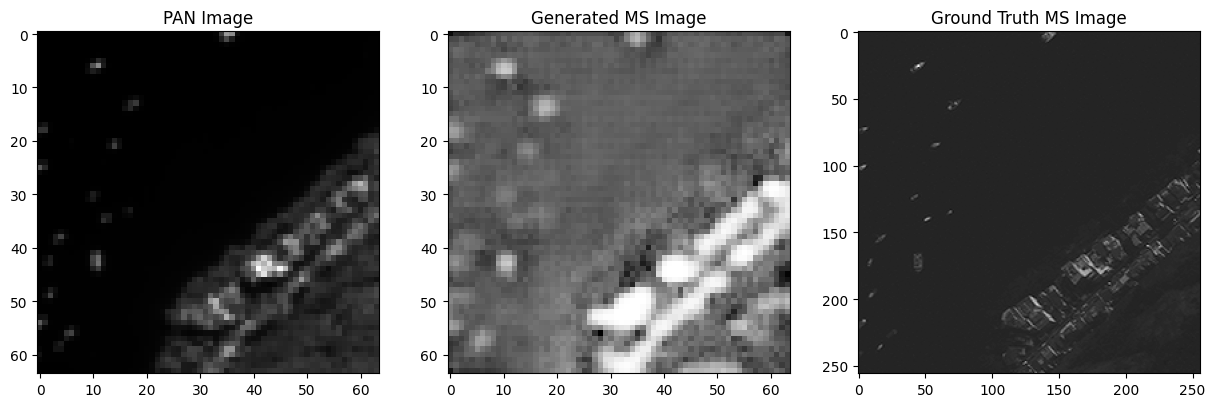

Sample 0: PSNR: 18.90530190643499, SSIM: 0.010476261791725493
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


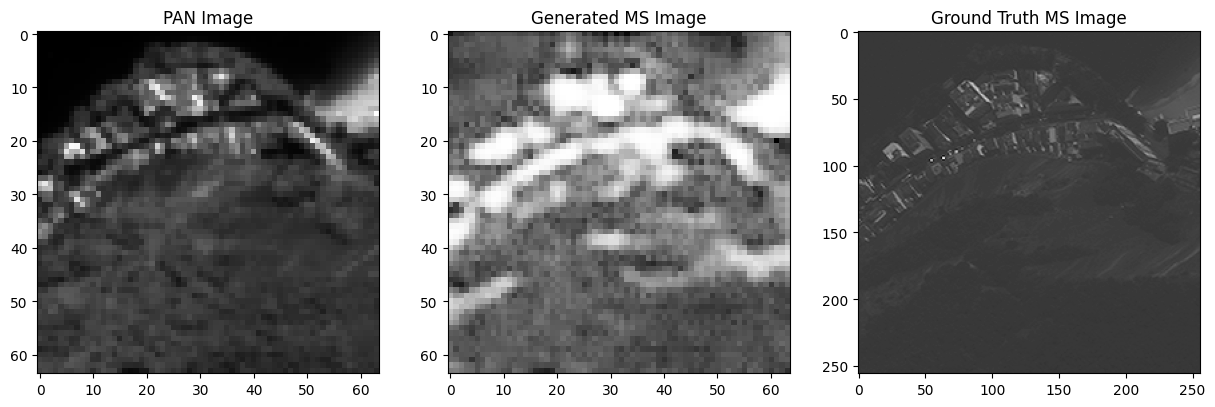

Sample 1: PSNR: 15.394338480025944, SSIM: 0.0032184749025810787
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


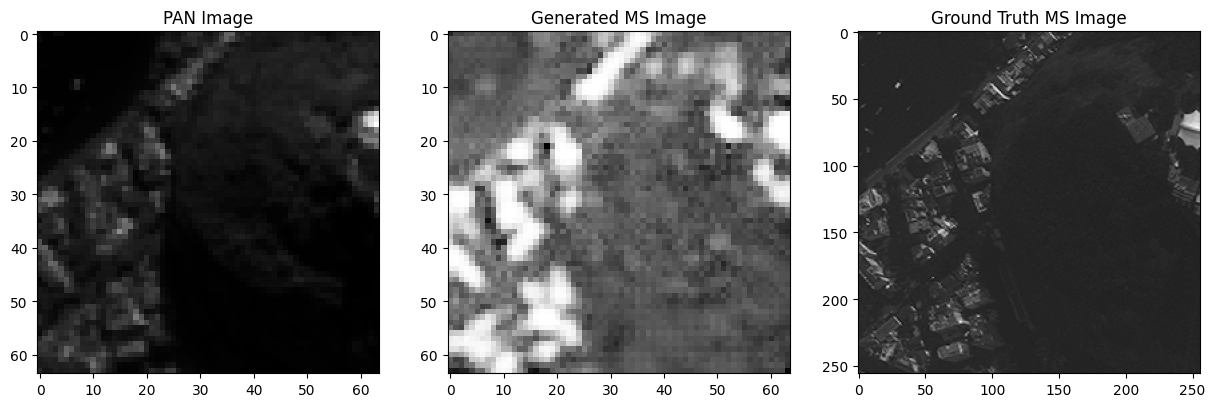

Sample 2: PSNR: 17.19513756078285, SSIM: 0.0068774200123331245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


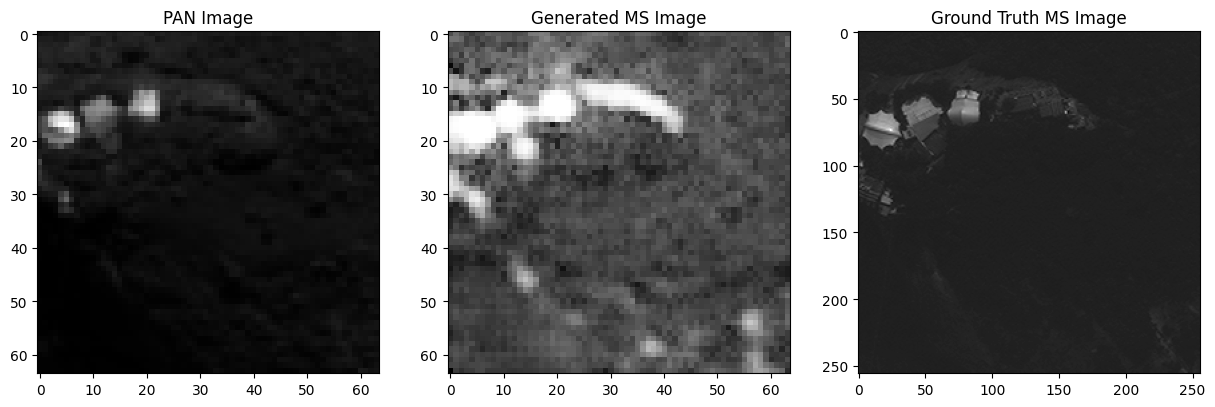

Sample 3: PSNR: 16.946039229743228, SSIM: 0.0057359654741185005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


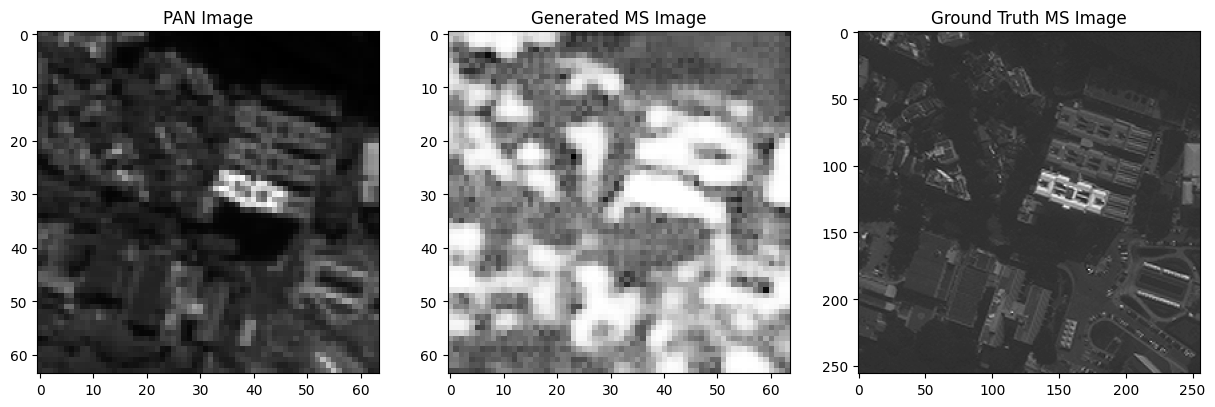

Sample 4: PSNR: 15.534848596670383, SSIM: 0.003931250400330539


In [ ]:
# Load the test dataset
class HDF5PansharpeningDataLoader(tf.keras.utils.Sequence):
    def __init__(self, h5_file_path, batch_size=1):
        self.h5_file_path = h5_file_path
        self.batch_size = batch_size
        with h5py.File(self.h5_file_path, 'r') as h5_file:
            self.pan_data = h5_file['pan'][:]
            self.ms_data = h5_file['ms'][:]
            self.gt_data = h5_file['gt'][:]

    def __len__(self):
        return int(np.ceil(len(self.pan_data) / self.batch_size))

    def __getitem__(self, idx):
        batch_pan = self.pan_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_ms = self.ms_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_gt = self.gt_data[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Prepare batches for input to the model
        pan_batch, ms_batch = [], []
        for pan_image, ms_image in zip(batch_pan, batch_ms):
            ms_image_upsampled = resize(ms_image.transpose(1, 2, 0), (64, 64), anti_aliasing=True)
            pan_image = resize(pan_image.transpose(1, 2, 0), (64, 64), anti_aliasing=True)
            ms_batch.append(ms_image_upsampled.transpose(2, 0, 1))
            pan_batch.append(pan_image.transpose(2, 0, 1))

        pan_batch = np.array(pan_batch).astype('float32') / 255.0
        ms_batch = np.array(ms_batch).astype('float32') / 255.0
        input_batch = np.concatenate([pan_batch, ms_batch], axis=1)
        return input_batch.transpose(0, 2, 3, 1), batch_gt.transpose(0, 2, 3, 1)

# Load the pretrained generator model
trained_generator = tf.keras.models.load_model('generator_epoch_50.keras')

# Define PSNR and SSIM evaluation metrics
def evaluate_metrics(gt_batch, generated_images):
    psnr_values = []
    ssim_values = []

    for i in range(gt_batch.shape[0]):
        gt_image = gt_batch[i]
        generated_image = generated_images[i]

        # Ensure the shapes are the same by resizing if needed
        if gt_image.shape != generated_image.shape:
            generated_image_resized = resize(generated_image, gt_image.shape, anti_aliasing=True)
        else:
            generated_image_resized = generated_image

        # Compute PSNR and SSIM
        psnr_value = psnr(gt_image, generated_image_resized, data_range=gt_image.max() - gt_image.min())
        ssim_value = ssim(gt_image, generated_image_resized, data_range=gt_image.max() - gt_image.min(), multichannel=True)
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    return avg_psnr, avg_ssim

# Visualize generated images
def visualize_images(input_image, generated_image, gt_image):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Show the PAN image (first channel of input)
    ax[0].imshow(input_image[:, :, 0], cmap='gray')
    ax[0].set_title('PAN Image')

    # Show the generated MS image (first channel of generated output)
    ax[1].imshow(generated_image[:, :, 0], cmap='gray')
    ax[1].set_title('Generated MS Image')

    # Show the ground truth MS image (first channel of ground truth)
    ax[2].imshow(gt_image[:, :, 0], cmap='gray')
    ax[2].set_title('Ground Truth MS Image')

    plt.show()

# Visualize and evaluate results after loading the model
def visualize_and_evaluate(generator, h5_file_path, num_samples=5):
    dataloader = HDF5PansharpeningDataLoader(h5_file_path, batch_size=1)

    for i, (input_batch, gt_batch) in enumerate(dataloader):
        if i >= num_samples:
            break

        # Generate images using the trained generator
        generated_images = generator.predict(input_batch)

        # Convert tensors to numpy arrays
        input_image = input_batch[0]
        generated_image = generated_images[0]
        gt_image = gt_batch[0]

        # Visualize the images
        visualize_images(input_image, generated_image, gt_image)

        # Evaluate PSNR and SSIM
        psnr_value, ssim_value = evaluate_metrics(gt_batch, generated_images)
        print(f"Sample {i}: PSNR: {psnr_value}, SSIM: {ssim_value}")

# Path to your test dataset
h5_test_file_path = '/content/drive/MyDrive/pansharpening/test_wv3_multiExm1.h5'

# Visualize and evaluate on test data
visualize_and_evaluate(trained_generator, h5_test_file_path, num_samples=5)
